## Apply the Naive Bayes model

In [1]:
#--IMPORTANT--#
#-- Please use 'pip install <missed-pakage>' to download the needed pakage. --#
#-- For loading the file, please put the .csv file and .ipynb file in the same folder --#
#-----------------------------------------------------------------------------#
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as m
from tabulate import tabulate
label_z = 0
label_o = 1

#This function convert all labels into 0 and 1
def convert_label(file):
    #For easier reading, change ">50K" to 1 and "<=50K" to 0
    file["label"] = file["label"].astype(str).str.replace(" >50K", "1")
    file["label"] = file["label"].astype(str).str.replace(" <=50K", "0")
    return file

# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing
# and implement 90-10 splitting as specified in the project description.
def preprocess(filename):
    data = pd.read_csv(filename)
    #Covert label into int
    data = convert_label(data)

    split_ratio = 0.9   #The length of the input file
    f_len = len(data) #File length
    split_num = split_ratio*f_len
    #Split data into tranning:%90, test:%10
    x_train = data.iloc[: int(split_num), : -1]
    x_test =  data.iloc[int(split_num) :, : -1]
    y_train = data.iloc[: int(split_num), -1:]
    y_test = data.iloc[int(split_num) :,-1:]
    return x_train, x_test, y_train, y_test

In [2]:
#This function will collect all nominal and numeric attributes
#Should iptut x_train
def collect_num_and_nom_atts(df):
    att_num = len(df.columns)   #Number of all columns(Include the label column)
    nom_atts = []
    num_atts = []
    for i in range(att_num):
        if(df.dtypes[i] == 'O'):
            nom_atts.append(df.columns[i])
        else:
            num_atts.append(df.columns[i])
    return nom_atts, num_atts


In [3]:
#Calculate log prior probabilities
def calculate_log_prior(data, label):
    count = 0
    log_prior = 0
    for i in range(len(data)):
        if(data['label'].iloc[i] == label):
            count +=1 

    log_prior = np.log(count/len(data))

    return log_prior

#Calculate log standard deviation and mean
#Input should be x&y_data, " att" and "0/1"
def calculate_sd_and_mean(x_data, y_data, att, label):
    count = 0
    sd = 0
    sum = 0
    atts = []
    #Loop the data, add values
    for i in range(len(x_data)):
        #Only add a value if it's picked and not ? 
        if(y_data["label"].iloc[i] == label and x_data[att].iloc[i] != "?"):
            count +=1 
            atts.append(x_data[att].iloc[i])
    mean = np.mean(atts)

    for i in range(count):
        sum += m.pow((atts[i]-mean), 2)
    sd = m.sqrt(sum / (count - 1))

    return sd, mean   


In [4]:
#Store mean and sd of all num attributes
#i.e. 'age', 'education num', 'hours per week'
def store_sd_and_mean(x_train, y_train, num_atts):
    zero_mean_list = []
    zero_sd_list = []
    one_mean_list = []
    one_sd_list = []
    dataframe_list = []

    #Calculate standard deviation and mean 
    for att in num_atts:
        z_sd, z_mean = calculate_sd_and_mean(x_train, y_train, att, "0")
        zero_sd_list.append(z_sd) 
        zero_mean_list.append(z_mean) 

        o_sd, o_mean = calculate_sd_and_mean(x_train, y_train, att, "1")
        one_sd_list.append(o_sd) 
        one_mean_list.append(o_mean)

    #Store these lists in a dataframe
    dataframe_list.append(zero_sd_list)
    dataframe_list.append(zero_mean_list)
    dataframe_list.append(one_sd_list)
    dataframe_list.append(one_mean_list)

    #Build dataframe
    data_frame = pd.DataFrame(dataframe_list, 
    index = ["zero_sd", "zero_mean", "one_sd", "one_mean"],
    columns=num_atts)
    return  data_frame


#Count the 0s and 1s of input y_data
def count_zeros_and_ones(y_data):
    zero_count = 0
    one_count = 0

    for i in range(len(y_data)):
        if(y_data["label"].iloc[i] == "0"):
            zero_count += 1
        else:
            one_count += 1
    
    return zero_count, one_count


#Count the likelihood of a specific value of nominal attributs under Y and N conditions
#Should input x&&y_data, att, " value", sum of 0s&&1s
def count_nom_likeliood(x_data, y_data, att, value, z_num, o_num):
    one_sum = 0
    zero_sum = 0
    total_sum = 0
    z_freq = 0
    o_freq = 0
    #Count the total labels number and each labels number
    for i in range(len(x_data)):
        if(x_data[att].iloc[i] == value and y_data['label'].iloc[i] == "0"):
            zero_sum += 1
            total_sum += 1
        elif(x_data[att].iloc[i] == value and y_data['label'].iloc[i] == "1"):
            one_sum += 1
            total_sum += 1
    #Calculate label 0 and 1's log frequency
    #Ignore result 0 
    if (zero_sum/z_num != 0 and one_sum/o_num != 0):
        z_freq = np.log(zero_sum/z_num)
        o_freq = np.log(one_sum/o_num)

    return z_freq, o_freq


#Store all the likelihoods of all nomial attributes in a dataframe
def store_nom_likelihood(x_data, y_data):
    whole_lh_list = []
    nom_atts, num_atts = collect_num_and_nom_atts(x_data)
    zero_count, one_count = count_zeros_and_ones(y_data)
    
    #Add all nominal likelihoods into whole_lh_list
    #Loop the nominal attributes
    for att in nom_atts:
        value_list = list(set(x_train[att]))    #The unique attributes
        z_lh_list = []
        o_lh_list = []
        #Loop the unique attributes
        for val in value_list:
            z_freq, o_freq = count_nom_likeliood(x_train, y_train, att, val, zero_count, one_count)
            #Stroe the current 0 and 1 likelihood into seperate lists
            z_lh_list.append(z_freq)
            o_lh_list.append(o_freq)
        #Store the 0 and 1 likelihood as a pair
        whole_lh_list.append((z_lh_list, o_lh_list))

    #Add whole_lh_list into a dataframe
    data_frame = []
    for i in range(len(whole_lh_list)):
        df = pd.DataFrame([whole_lh_list[i][0], whole_lh_list[i][1]], columns=[list(set(x_train[nom_atts[i]]))])
        data_frame.append(df)
    return data_frame



In [5]:
# This function should calculate prior probabilities and likelihoods (conditional probabilities) from the training data and using
# to build a naive Bayes model
def train(x_train,y_train):
    label_val1 = "0"
    label_val2 = "1"
    nom_atts, num_atts = collect_num_and_nom_atts(x_train)

    log_prior_zero = calculate_log_prior(y_train, label_val1)
    log_prior_one = calculate_log_prior(y_train, label_val2)
    prior = pd.DataFrame([log_prior_zero,log_prior_one], columns=["log_prior"])
    
    df_sd_mean = store_sd_and_mean(x_train, y_train, num_atts)
    df_nom_lh = store_nom_likelihood(x_train, y_train)
   
    return prior, df_sd_mean, df_nom_lh



In [6]:
#Find the position of the numeric and nominal dttributes
def detect_nom_and_num_index(x_data):
    nom_index_list = []
    num_index_list = []

    for i in range(len(x_data.columns)):
        if(x_data.dtypes[i] == "O"):
            nom_index_list.append(i)
        else:
            num_index_list.append(i)
    
    return nom_index_list, num_index_list 

#Calculate log gaussian pdf
def calculate_num_likelihood(sd, mean, x_data):
    coefficient = 0
    power = 0
    result = 0
    #Don't do anything with "?"
    if(x_data != "?"):
        coefficient = 1/(sd*m.sqrt(2*m.pi))
        power = -0.5*(m.pow(((x_data - mean) / sd), 2))

        if(coefficient*pow(m.e, power) == 0):
            result = 0
        else:
            result = np.log(coefficient*pow(m.e, power))

    return result

In [7]:

#Sum the numeric likelihood of a single instance's numbers
def sum_num_likelihood(num_atts_df, df_sd_mean):
    zero_lh = 0
    one_lh = 0
    
    for i in range(len(num_atts_df)):
        x_value = num_atts_df[i]

        #Calculate likelihood of label 0 
        zero_sd = df_sd_mean[num_atts_df.index[i]][label_z]
        zero_mean = df_sd_mean[num_atts_df.index[i]][label_o]
        zero_lh += calculate_num_likelihood(zero_sd, zero_mean, x_value)

        #Calculate likelihood of label 1 
        one_sd = df_sd_mean[num_atts_df.index[i]][label_z+2]
        one_mean = df_sd_mean[num_atts_df.index[i]][label_o+2]
        one_lh += calculate_num_likelihood(one_sd, one_mean, x_value)
    
    return zero_lh, one_lh

#Sum the nominal likelihood of a single instance
def sum_nom_likelihood(nom_para, df_nom_lh):
    zero_lh = 0
    one_lh = 0
    nom_atts, num_atts = collect_num_and_nom_atts(x_train)
    
    #Loop the nominal parameter
    for i in range(len(nom_atts)):
        x_value = nom_para[i]
        #If the current parameter exits in the test case
        #calculate the likelihood
        if(x_value in df_nom_lh[i].columns):    
            zero_lh += df_nom_lh[i][x_value].iloc[label_z][0]
            one_lh += df_nom_lh[i][x_value].iloc[label_o][0]
    
    return zero_lh, one_lh


# This function should predict classes for new items in the testing data
def predict(x_test, prior, df_sd_mean, df_nom_lh):
    predict_list = []
    c_list = []
    z_o_c_list =[]
    nom_index_list, num_index_list = detect_nom_and_num_index(x_train)
    
    #Log prior for 1 and 0
    zero_prior = prior["log_prior"][label_z]
    one_prior =  prior["log_prior"][label_o]

    for i in range(len(x_test)):
        #Nom and num likelihood of a single instance
        zero_num_lh, one_num_lh = sum_num_likelihood(x_test.iloc[i, num_index_list], df_sd_mean)
        zero_nom_lh, one_nom_lh = sum_nom_likelihood(x_test.iloc[i, nom_index_list], df_nom_lh)
        
        #Final posibility of zero and one of a single instance
        zero_post_prior = zero_prior + zero_num_lh + zero_nom_lh
        one_post_prior = one_prior + one_num_lh + one_nom_lh
        #Store zero and one post prior in pairs
        z_o_c_list.append([zero_post_prior,one_post_prior])

        #Store the prediction (the higher posibility result)
        if(zero_post_prior > one_post_prior):
            predict_list.append(label_z)
            c_list.append(zero_post_prior)
        else:
            predict_list.append(label_o)
            c_list.append(one_post_prior)

    return predict_list, c_list, z_o_c_list


In [8]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels, return and output accuracy, confusion matrix and F1 score.

def evaluate(predict_list, y_test):
    #P = 0; N = 1
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    #Count each element of confussion table
    for i in range(len(predict_list)):
        if(predict_list[i] == 0 and y_test["label"].iloc[i] == "0"):
            TP += 1
        elif(predict_list[i] == 0 and y_test["label"].iloc[i] == "1"):
            FP += 1
        elif(predict_list[i] == 1 and y_test["label"].iloc[i] == "1"):
            TN += 1
        else:
            FN += 1

    #Calculte the ouput values
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    matrix = np.matrix([[TP,FN],[FP,TN]])
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f_score = (2 * precision * recall)/(precision + recall)

    print(f"Accuracy: {accuracy}")
    print(f"F1 score: {f_score}")
    print(f"Confusion matrix: \n{matrix}") 
    return accuracy, f_score, matrix


In [9]:
# This cell should act as your "main" function where you call the above functions 
# on the full ADULT data set, and print the evaluation results. [0.33 marks]
def convert_label_back(label):
    if(label == 0):
        return "<=50K"
    elif(label == 1):
        return ">50K"


# First, read in the data and apply your NB model to the ADULT data
file = "adult.csv"
x_train, x_test, y_train, y_test = preprocess(file)
prior, df_sd_mean, df_nom_lh = train(x_train,y_train)
predict_list, c_list,z_o_c_list = predict(x_test, prior, df_sd_mean, df_nom_lh)

# Second, print the full evaluation results from the evaluate() function
accuracy, f_score, matrix =  evaluate(predict_list, y_test)


# Third, print data statistics and model predictions, as instructed below 
# N is the total number of instances, F the total number of attributes, L the total number of labels
# The "class probabilities" may be unnormalized
# The "predicted class ID" must be in range (0, L)
print("Attribute vectors of instances [0, 1, 2]: ") # of the first three records in adult.csv
display(x_train.head(3))

print(f"\nNumber of instances (N): {len(x_train)+len(x_test)}")
print(f"Number of attributes (F): {len(x_train.columns)}")
print("Number of labels (L): ", len(set(y_test["label"])))


# print out the prediction results of the last three instances
pre_label1 = convert_label_back(predict_list[-1])
pre_label2 = convert_label_back(predict_list[-2])
pre_label3 = convert_label_back(predict_list[-3])

print(f"\n\nPredicted class log-probabilities for instance N-3: <=50K: {z_o_c_list[-3][0]}, >50K: {z_o_c_list[-3][1]}")
print("Predicted class ID for instance N-3: ", pre_label3)
print(f"\nPredicted class log-probabilities for instance N-2: <=50K: {z_o_c_list[-2][0]}, >50K: {z_o_c_list[-2][1]}")
print("Predicted class ID for instance N-2: ", pre_label2)
print(f"\nPredicted class log-probabilities for instance N-1: <=50K: {z_o_c_list[-1][0]}, >50K: {z_o_c_list[-1][1]}")
print("Predicted class ID for instance N-1: ", pre_label1)


Accuracy: 0.86
F1 score: 0.9078947368421053
Confusion matrix: 
[[69  8]
 [ 6 17]]
Attribute vectors of instances [0, 1, 2]: 


age         work class   education  education num       marital status  \
0   68                  ?     1st-4th              2             Divorced   
1   39          State-gov   Bachelors             13        Never-married   
2   50   Self-emp-not-inc   Bachelors             13   Married-civ-spouse   

         occupation    relationship    race      sex  hours per week  \
0                 ?   Not-in-family   White   Female              20   
1      Adm-clerical   Not-in-family   White     Male              40   
2   Exec-managerial         Husband   White     Male              13   

  native country (region)  
0           United-States  
1           United-States  
2           United-States


Number of instances (N): 1000
Number of attributes (F): 11
Number of labels (L):  2


Predicted class log-probabilities for instance N-3: <=50K: -20.716896981933054, >50K: -19.556273652832147
Predicted class ID for instance N-3:  >50K

Predicted class log-probabilities for instance N-2: <=50K: -25.339070637730188, >50K: -22.744589775643142
Predicted class ID for instance N-2:  >50K

Predicted class log-probabilities for instance N-1: <=50K: -16.852794958645738, >50K: -16.716481989445864
Predicted class ID for instance N-1:  >50K


## Calculate the sensitivity and specificity and analysing the difference between them. Suggestions to improve the model performance. 

In [10]:

#The cell displays the quantity of label values in
#y_test and y_train
TP = matrix[0, 0]
FN = matrix[0, 1]
FP = matrix[1, 0]
TN = matrix[1, 1]

#Display the evaluation results
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
# assign data
mydata1 = [["Sensitivity"] + [sensitivity]]
mydata2 = [["Specificity"] + [specificity]]
mydata_tt = mydata1 + mydata2
# display table
print(tabulate(mydata_tt, tablefmt="grid"))

#Count the label distribution
def count_labels(dataset):
    count_zero = 0
    count_one = 0
    #Find the number of 0 and 1
    for i in range(len(dataset)):
        if(y_train["label"].iloc[i] == "0"):
            count_zero += 1
        elif(y_train["label"].iloc[i] == "1"):
            count_one += 1

    return count_zero, count_one

train_zeros, train_ones = count_labels(y_train)
test_zeros, test_ones = count_labels(y_test)

#Display the label distribution
# assign data
mydata1 = [[" <=50K"] + [train_zeros] + [test_zeros] ]
mydata2 = [[" >50K"] + [train_ones] + [test_ones]]
mydata_tt = mydata1 + mydata2
# create header
head = [" "] + ["Train data"]+ ["Test data"]
# display table
print(tabulate(mydata_tt, headers=head, tablefmt="grid"))


+-------------+----------+
| Sensitivity | 0.896104 |
+-------------+----------+
| Specificity | 0.73913  |
+-------------+----------+
+-------+--------------+-------------+
|       |   Train data |   Test data |
+=======+==============+=============+
| <=50K |          692 |          75 |
+-------+--------------+-------------+
| >50K  |          208 |          25 |
+-------+--------------+-------------+


Sensitivity shows the ability of a model to detect the proportion of true positive cases. And, specificity shows the ability about detecting the true negative cases. According to the results, the sensitivity is a bit higher than the specificity, the difference is around 0.1. It means this model performs better in predicting true positive cases.    

Based on the data distribution, the overall ratio of label values in the dataset is about 3(<=50K):1(>50K). It means the prior possibility of (<=50K) is greater, and the value of TP will be greater than TN as well. According to the formulas, the model may tend to predict the label as "<=50K" due to the greater prior. This may also cause the value of sensitivity to be greater than Specificity because the sensitivity has a greater numerator.

For improving this model, balanced labels might be helpful. For example, when there are other extra instances, it's good to pick more data of label ">50K". On the other hand, picking more instances without missing attributes may also improve the model.

### 1.Instead of Gaussian, implement KDE for $P(X_i|c_j)$ for numeric attributes $X_i$. Compare the evaluation results with Gaussian. 

### 2.Implement <u>10-fold and 2-fold cross-validations</u>. Analyse the evaluation results in each fold and the average accuracy, recall and specificity over all folds. 

In [11]:
#This fucntion calculate Gussian pdf
def calculate_g_pdf(x, xi, bandwidth):
    coefficient = 0
    power = 0
    result = 0
    #Don't do anything with "?"
    if(x != "?" and xi != "?"):
        coefficient = 1/(bandwidth*m.sqrt(2*m.pi))
        power = -0.5*(m.pow(((x - xi) / bandwidth), 2))
        result = coefficient*pow(m.e, power)
    
    return result

#This function calculate KDE pdf
def calculate_KDE_pdf(x, bandwidth, label_atts):
    KDE_list = []
    mean = 0
    #label_atts inlcudes the rows of the same label(0/1)
    #Loop the label_atts, calculate the gaussian pdf of each x_value
    for x_value in label_atts.index:
        xi = label_atts[x_value]
        #Add the result into the list
        KDE_list.append(calculate_g_pdf(x, xi, bandwidth))

    mean = np.mean(KDE_list)    #The mean of the list
    if(mean == 0):
        return 0
    else:
        return np.log(mean)

#This function store the KED likelihood in a dataframe
def store_KED_likelihood(x_train, x_test, y_train, num_atts, bandwidth):
    para_list = []
    zero_index = y_train.loc[y_train["label"] == "0"].index
    one_index = y_train.loc[y_train["label"] == "1"].index
    
    #Find each attrtribute with specific labels (0/1) 
    for att in num_atts:
        zero_att = x_train.loc[zero_index, att]
        one_att = x_train.loc[one_index, att]

        zero_list = []
        one_list = []

        #Calculate total KDE pdf, the cluster is based on label
        for i in x_test.index:
            x = x_test[att][i]

            zero_list.append(calculate_KDE_pdf(x, bandwidth, zero_att))
            one_list.append(calculate_KDE_pdf(x, bandwidth, one_att))
        #Add result into a list
        para_list.append(zero_list)
        para_list.append(one_list)
    #Make the list a dataframe
    dataframe = pd.DataFrame(para_list, index = ["zero_age", "one_age", "zero_education", "one_education", "zero_h_per_w", "one_h_per_w"])
    return dataframe


In [12]:

# This function should calculate prior probabilities and likelihoods (conditional probabilities) from the training data and using
# to build a naive Bayes model
def train_KDE(x_train, x_test, y_train, bandwidth):
    label_val1 = "0"
    label_val2 = "1"
    nom_atts, num_atts = collect_num_and_nom_atts(x_train)

    log_prior_zero = calculate_log_prior(y_train, label_val1)
    log_prior_one = calculate_log_prior(y_train, label_val2)
    prior = pd.DataFrame([log_prior_zero,log_prior_one], columns=["log_prior"])
    
    df_KDE_lh = store_KED_likelihood(x_train, x_test, y_train, num_atts, bandwidth)
    df_nom_lh = store_nom_likelihood(x_train, y_train)
   
    return prior, df_KDE_lh, df_nom_lh

# This function should predict classes for new items in the testing data
def predict_KDE(x_test, prior, df_KDE_lh, df_nom_lh):
    predict_list = []
    c_list = []
    z_o_c_list =[]
    nom_index_list, num_index_list = detect_nom_and_num_index(x_train)
    
    #Log prior for 1 and 0
    zero_prior = prior["log_prior"][label_z]
    one_prior =  prior["log_prior"][label_o]

    for i in range(len(x_test)):
        #Nom and num likelihood of a single instance
        zero_num_lh = df_KDE_lh[i]["zero_age"] + df_KDE_lh[i]["zero_education"] + df_KDE_lh[i]["zero_h_per_w"]
        one_num_lh = df_KDE_lh[i]["one_age"] + df_KDE_lh[i]["one_education"] + df_KDE_lh[i]["one_h_per_w"]
        zero_nom_lh, one_nom_lh = sum_nom_likelihood(x_test.iloc[i, nom_index_list], df_nom_lh)
        
        #Final posibility of zero and one of a single instance
        zero_post_prior = zero_prior + zero_num_lh + zero_nom_lh
        one_post_prior = one_prior + one_num_lh + one_nom_lh
        #Store zero and one post prior in pairs
        z_o_c_list.append([zero_post_prior,one_post_prior])

        #Store the prediction (the higher posibility result)
        if(zero_post_prior > one_post_prior):
            predict_list.append(label_z)
            c_list.append(zero_post_prior)
        else:
            predict_list.append(label_o)
            c_list.append(one_post_prior)

    return predict_list, c_list, z_o_c_list

#This function used the previous evlauate function to calculate the 
#accuracy, F-score and confusion table matrix
def evalueate_KDE(x_train, x_test, y_train, y_test, bandwidth):
    prior_KDE, df_KDE_lh, df_nom_lh = train_KDE(x_train, x_test, y_train, bandwidth)
    predict_list_KDE, c_list_KDE, z_o_c_list_KDE = predict_KDE(x_test, prior_KDE, df_KDE_lh, df_nom_lh)
    accuracy_KDE, f_score_KDE, matrix_KDE =  evaluate(predict_list_KDE, y_test)
    return accuracy_KDE, f_score_KDE, matrix_KDE


Accuracy: 0.86
F1 score: 0.9066666666666665
Confusion matrix: 
[[68  9]
 [ 5 18]]
Accuracy: 0.81
F1 score: 0.8689655172413794
Confusion matrix: 
[[63 14]
 [ 5 18]]
Accuracy: 0.82
F1 score: 0.8750000000000001
Confusion matrix: 
[[63 14]
 [ 4 19]]
Accuracy: 0.81
F1 score: 0.8671328671328672
Confusion matrix: 
[[62 15]
 [ 4 19]]
Accuracy: 0.82
F1 score: 0.8750000000000001
Confusion matrix: 
[[63 14]
 [ 4 19]]


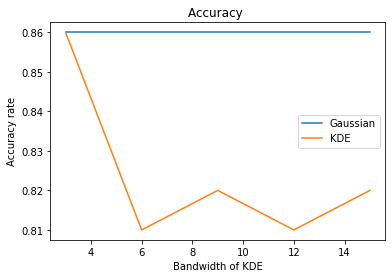

In [13]:
#This cell is used to detect the results of KED and Gaussian algorithm
#and discuss their differences 
#Check the evaluation from bandwidth 3 to 15, gap is 3.
accuracy_KDE_list = []
for i in range(3, 16, 3):
    accuracy_KDE, f_score_KDE, matrix_KDE = evalueate_KDE(x_train, x_test, y_train, y_test, i)
    accuracy_KDE_list.append(accuracy_KDE)


x = np.arange(3, 16, 3) 
y1 = [accuracy]*5
y2 = np.array(accuracy_KDE_list)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)

# Add Title
plt.title("Accuracy ") 

# Add Axes Labels and legend
plt.xlabel("Bandwidth of KDE") 
plt.ylabel("Accuracy rate") 
plt.legend(['Gaussian','KDE'])
# Display
plt.show()

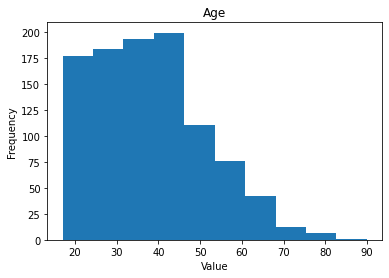

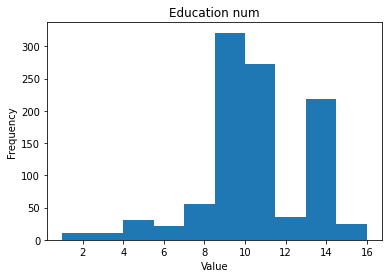

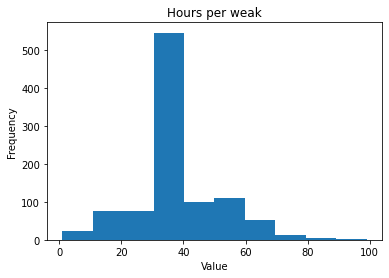

In [14]:
#This cell shows the plots of numeric attributes
#Can obersve the disttributions of those values
age_list = []
education_num_list = []
h_per_w_list = []
num_locs = []
nom_locs = []
nom_locs, num_locs = detect_nom_and_num_index(x_train)

#Store all the numeric attributes of all instances
with open("adult.csv",'r') as f: #No need to close file when using 'with ... as ...'s
    f.readline()    #Ignore the first line
    for line in f:
        att_vals = line.strip().split(",")
        currrent_round = 0
        for loc in num_locs:
            #Ignore "?"
            if(not(att_vals[loc]) == "?"):
                if currrent_round == 0: age_list.append(float(att_vals[loc]))
                elif currrent_round == 1: education_num_list.append(float(att_vals[loc]))
                elif currrent_round == 2: h_per_w_list.append(float(att_vals[loc]))
            currrent_round += 1

#Plot numeric data
#Observe their data distributions
plt.title("Age")
plt.hist(np.array(age_list))
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.title('Education num')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.hist(np.array(education_num_list))
plt.show()

plt.title('Hours per weak')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.hist(np.array(h_per_w_list))
plt.show()

In [15]:
# This function should evaliate the prediction performance by comparing the model’s class outputs to ground
# truth labels, return and output accuracy, recall and specificity

def evaluate_cv(predict_list, y_test):
    #P = 0; N = 1
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    #Count each element of confussion table
    for i in range(len(predict_list)):
        if(predict_list[i] == 0 and y_test["label"].iloc[i] == "0"):
            TP += 1
        elif(predict_list[i] == 0 and y_test["label"].iloc[i] == "1"):
            FP += 1
        elif(predict_list[i] == 1 and y_test["label"].iloc[i] == "1"):
            TN += 1
        else:
            FN += 1

    #Calculte the ouput values
    accuracy_cv = (TP + TN)/(TP + TN + FP + FN)
    recall_cv = TP/(TP + FN)
    specificity_cv = TN / (TN + FP)

    return accuracy_cv, recall_cv, specificity_cv


#This function build the k-fold cross validation model
def kf_cv_model(filename, k):
    file = pd.read_csv(filename)
    
    #Covert label into int
    file = convert_label(file)
    file_len = len(file)    #The number of rows
    split_rate = 1/k
    fold_size = split_rate*file_len   #The size of each fold

    accuracy_cv_list = []
    recall_cv_list = []
    specificity_cv_list = []

    for i in range(k):
        test_index = []
        #The rows index of the test data
        test_index = list(range(int(i * fold_size), int((i+1) * fold_size)))
        #The rows index of the train data
        train_index = file.index.drop(test_index)

        #Split the data
        x_train_cv = file.iloc[train_index, : -1]
        x_test_cv =  file.iloc[test_index, : -1]
        y_train_cv = file.iloc[train_index, -1:]
        y_test_cv = file.iloc[test_index, -1:]

        #Do the train(), predict() and evaluate()
        prior_cv, df_sd_mean_cv, df_nom_lh_cv = train(x_train_cv, y_train_cv)
        predict_list_cv, c_list_cv,z_o_c_list_cv = predict(x_test_cv, prior_cv, df_sd_mean_cv, df_nom_lh_cv)
        accuracy_cv, recall_cv, specificity_cv =  evaluate_cv(predict_list_cv, y_test_cv)

        #Store the ressult into lists
        accuracy_cv_list.append(accuracy_cv)
        recall_cv_list.append(recall_cv)
        specificity_cv_list.append(specificity_cv)

    return accuracy_cv_list, recall_cv_list, specificity_cv_list

In [16]:
#Run the 10-fold CV nad 2-dold CV, store the outputsseperately
accuracy_cv_list_10, recall_cv_list_10, specificity_cv_list_10 = kf_cv_model("adult.csv", 10)
accuracy_cv_list_2, recall_cv_list_2, specificity_cv_list_2 = kf_cv_model("adult.csv", 2)

In [17]:
#The result of 10-fold cross validation
# assign data
mydata_ten = [["Accuracy"] + accuracy_cv_list_10] + [["Recall"] + recall_cv_list_10] + [["Specificity"] + specificity_cv_list_10]
# create header
head_ten = ["Execute order"] + list(range(1,11)) 
# display table
print(tabulate(mydata_ten, headers=head_ten, tablefmt="grid"))

#The comparison between 2-fold and 10-fold
# assign data
mydata1 = [["10-fold CV"] + [np.mean(accuracy_cv_list_10)] + [np.mean(recall_cv_list_10)] + [np.mean(specificity_cv_list_10)]]
mydata2 = [["2-fold CV"] + [np.mean(accuracy_cv_list_2)] + [np.mean(recall_cv_list_2)] + [np.mean(specificity_cv_list_2)]]
mydata_tt = mydata1 + mydata2
# create header
head = [" "] + ["Accuracy"]+ ["Recall"] + ["Specificity"]
# display table
print(tabulate(mydata_tt, headers=head, tablefmt="grid"))

+-----------------+------+----------+----------+----------+------+----------+----------+----------+----------+----------+
| Execute order   |    1 |        2 |        3 |        4 |    5 |        6 |        7 |        8 |        9 |       10 |
+=================+======+==========+==========+==========+======+==========+==========+==========+==========+==========+
| Accuracy        | 0.79 | 0.84     | 0.8      | 0.86     | 0.86 | 0.82     | 0.81     | 0.78     | 0.81     | 0.86     |
+-----------------+------+----------+----------+----------+------+----------+----------+----------+----------+----------+
| Recall          | 0.76 | 0.833333 | 0.818182 | 0.87013  | 0.9  | 0.835443 | 0.844156 | 0.815789 | 0.849315 | 0.896104 |
+-----------------+------+----------+----------+----------+------+----------+----------+----------+----------+----------+
| Specificity     | 0.88 | 0.863636 | 0.73913  | 0.826087 | 0.7  | 0.761905 | 0.695652 | 0.666667 | 0.703704 | 0.73913  |
+-----------------+-----

(a) 
Based on the "Accuracy" plot, the Gaussian algorithm has higher overall accuracy than the KDE algorithm, besides the case when the bandwidth is 3. The KED algorithm's accuracy shifts around 0.82, while the Gaussian algorithm's accuracy is 0.86. This phenomenon reveals that the Gaussian algorithm performs better in this dataset.

By observing the histograms of the numeric attributes, their overall distributions are a bit similar to the Gaussian distribution, especially the "Age" and "Hours per week". Since Gaussian naive Bayes usually performs better in predicting data with Gaussian distribution, the Gaussian algorithm has higher accuracy and it's more suitable for this dataset. However, when the data distribution is far from the Gaussian distribution, KED naive Bayes may perform better. 

(b)
By observing the first table, the 10-fold CV's accuracy, recall, and specificity are about 0.8. And the second table shows the 2-fold CV performs a bit better than the 10-fold CV. That shows that a less m value may lead to a better result, but it is hard to determine if it's a coincidence. The greater m may display a worse result, but it's closer to the realistic performance of the model since it trains more data and tests more times. Furthermore, the increasing value of m will also lead to a longer execution time, so it's important to pick a proper m value. 